In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import models
import time
import glob
import PIL
import os
from PIL import Image

In [2]:
DATA_PATH='RSI-CB256/data'

# Defining image transformations
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    # Normalize the image
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [3]:
# Defining hyperparameters
batch_size = 32
num_epochs = 30
learning_rate = 0.0003

In [4]:
data = datasets.ImageFolder(DATA_PATH, transform = transform) # Fetching dataset from folder

# train-test split
train_size = int(0.7 * len(data)) 
test_size = int(0.2 * len(data))
val_size = int(len(data) - (train_size+test_size))
train_dataset, test_dataset, val_dataset = random_split(data, [train_size, test_size, val_size])


print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 
print(f"Validation Dataset has {len(val_dataset)} data points.") 

Dataset has 5631 data points.
Train Dataset has 3941 data points
Test Dataset has 1126 data points.
Validation Dataset has 564 data points.


In [5]:
train_loader = DataLoader(train_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, num_workers=2, shuffle= True)

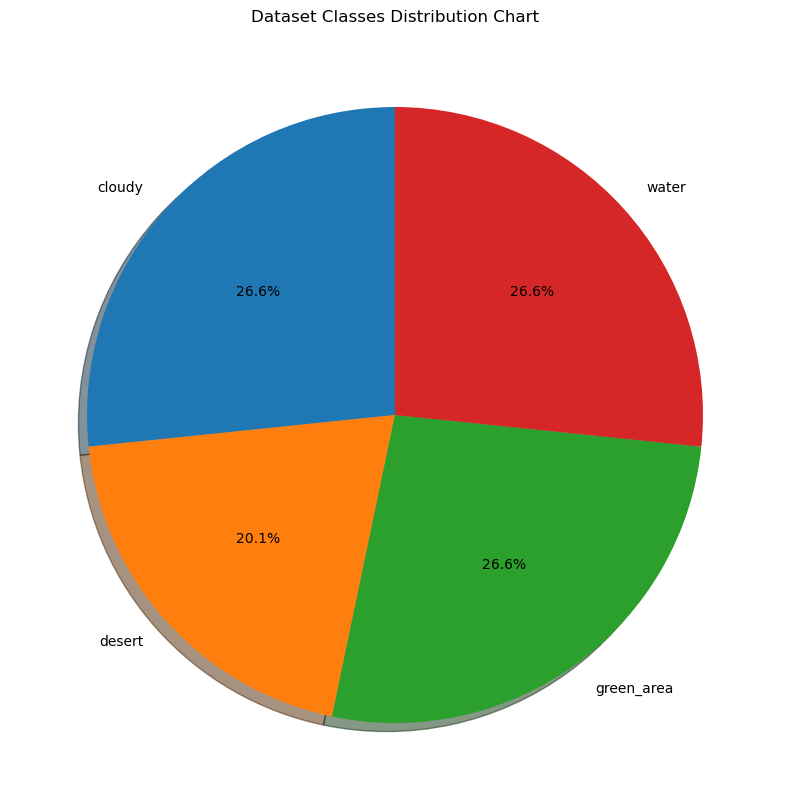

{'cloudy': 1499, 'desert': 1130, 'green_area': 1499, 'water': 1499}


In [6]:
# Visualizing data distrubitons accordin to classes
class_names_train = os.listdir(DATA_PATH)

image_count = {}
for i in class_names_train:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i))) - 1

    
# Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        textprops=dict(color="black"),
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Dataset Classes Distribution Chart", color='black')
plt.show()
print(image_count)

In [7]:
# Defining Model
model = models.densenet121()

for param in model.parameters():
    param.require_grad = False
    
fc = nn.Sequential(
    nn.Linear(1024,460),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(460, 5)
)

model.classifier = fc
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Device: cuda:0


In [8]:
# num_epochs = 5

total_steps = len(train_loader)
t1 = time.time()
train_accuracy = []
val_accuracy = []
training_loss = []
epoch_accuracy = 0
total_label_i = 0
validation_loss=[]


for epoch in range(num_epochs):
    epoch_loss = 0
    correct_v=0 
    correct=0 
    total_v=0 
    total=0
    train_loss =0.0 
    
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total += labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item() 
        
        total_label_i += total;
        epoch_accuracy += (predicted == labels).float().sum()
        
    valid_loss=0.0;
    for i_v, data_v in enumerate(val_loader):
        images_v, labels_v = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs_v = model(images_v)
        loss_v = criterion(outputs_v, labels_v)
        total_v += labels_v.size(0)
        _,predicted_v = torch.max(outputs_v.data, 1)
        correct_v += (predicted_v == labels_v).sum().item()
        valid_loss += loss_v.item()
    
    train_accuracy.append(round((correct/total)*100, 2))
    val_accuracy.append(round((correct_v/total_v)*100, 2))
    training_loss.append(train_loss/len(train_loader))
    validation_loss.append(valid_loss/len(val_loader))

    print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
        .format(epoch + 1, num_epochs, (train_loss/len(train_loader)), (valid_loss/len(val_loader)), (correct / total) * 100, 
          (correct_v / total_v) * 100))
            
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/30], Training Loss: 0.4269, Validation Loss: 0.3680, Training Accuracy: 84.55%, Validation Accuracy: 78.89%
Epoch [2/30], Training Loss: 0.2779, Validation Loss: 0.3194, Training Accuracy: 90.18%, Validation Accuracy: 80.00%
Epoch [3/30], Training Loss: 0.1868, Validation Loss: 0.6618, Training Accuracy: 93.25%, Validation Accuracy: 80.00%
Epoch [4/30], Training Loss: 0.1706, Validation Loss: 0.0307, Training Accuracy: 94.09%, Validation Accuracy: 100.00%
Epoch [5/30], Training Loss: 0.1636, Validation Loss: 0.0370, Training Accuracy: 94.67%, Validation Accuracy: 100.00%
Epoch [6/30], Training Loss: 0.2144, Validation Loss: 0.4979, Training Accuracy: 92.84%, Validation Accuracy: 80.00%
Epoch [7/30], Training Loss: 0.1814, Validation Loss: 0.7402, Training Accuracy: 94.16%, Validation Accuracy: 80.00%
Epoch [8/30], Training Loss: 0.1916, Validation Loss: 0.8873, Training Accuracy: 94.27%, Validation Accuracy: 57.78%
Epoch [9/30], Training Loss: 0.1622, Validation Loss: 0.9910, 

In [9]:
# Calculating Test Accuracy
model.eval() 

with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 1126 test images: 51.776198934280636 %


In [10]:
print(training_loss)
print(validation_loss)

[0.4268854633574524, 0.2779465657208235, 0.1867843239207662, 0.17056735936972883, 0.1635854971114426, 0.21440367049147044, 0.1813662657213788, 0.191601749329317, 0.16219663682333643, 0.12647099909372628, 0.12477717011596166, 0.10477771792530773, 0.1210816128708933, 0.09458802524022758, 0.13440188233019604, 0.13415616885158083, 0.10271231762899627, 0.1167729802790188, 0.11895982015712728, 0.10425549946470006, 0.08875108160258781, 0.11258035220746551, 0.15549691813817668, 0.0981324877995517, 0.08242643442034962, 0.10741185026633884, 0.08180079093172905, 0.10578623791075041, 0.13597747520543635, 0.10521001702610162]
[0.36795925431781346, 0.3193713029225667, 0.6617894056770537, 0.03070974825984902, 0.036962089749674, 0.49790378080474007, 0.7401902973651886, 0.8872758746147156, 0.9909915394253201, 0.3753553148772981, 0.80446900261773, 0.07353334708346261, 0.009209978316600123, 0.010579217690974474, 0.4100495096709993, 2.1621095538139343, 0.17174534416861004, 1.1808173524008856, 0.8135892616

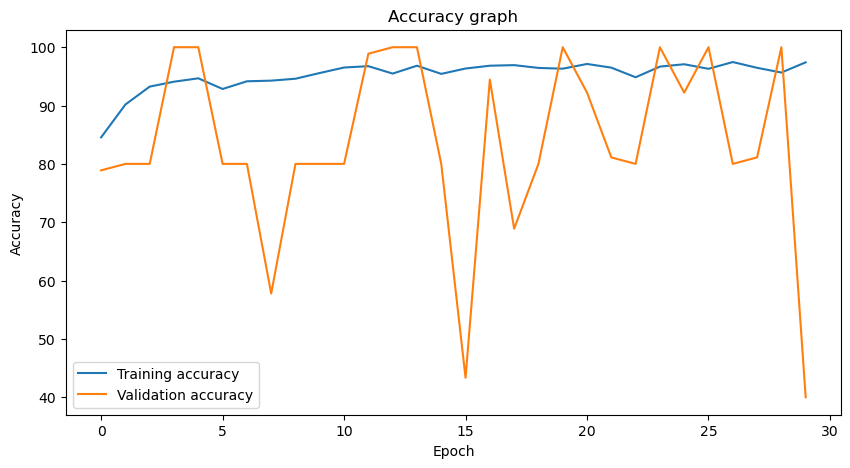

In [11]:
epochs = [i for i in range(num_epochs)]
plt.figure(figsize=(10,5))
plt.title("Accuracy graph")
plt.plot(epochs, train_accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

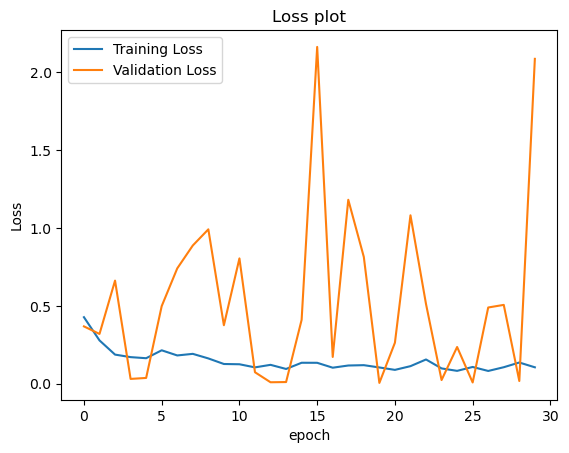

In [25]:
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')

plt.legend()

In [13]:
#T-SNE For RSI-CB

import random
import numpy as np
import pickle
from PIL import Image
from scipy.spatial import distance
import igraph
import cv2
import os
from skimage import io
from sklearn.feature_extraction import image 
from sklearn.manifold import TSNE
from tqdm import tqdm
%matplotlib inline

In [14]:
data = []
folder = 'RSI-CB256/data/'
fold=['cloudy/','desert/','green_area/','water/']
for f in fold:
    for filename in tqdm((os.listdir(folder+f))):
        image = cv2.imread(os.path.join(folder+f,filename))
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (45,45))
            image = image.flatten()
            data.append([image, folder+f+ filename])

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 3896.40it/s]


In [15]:
from sklearn.decomposition import PCA
features, images  = zip(*data)

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

num_images_to_plot = len(images)

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [16]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=350, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

C:\Users\solan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5631 samples in 0.004s...
[t-SNE] Computed neighbors for 5631 samples in 0.898s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5631
[t-SNE] Computed conditional probabilities for sample 2000 / 5631
[t-SNE] Computed conditional probabilities for sample 3000 / 5631
[t-SNE] Computed conditional probabilities for sample 4000 / 5631
[t-SNE] Computed conditional probabilities for sample 5000 / 5631
[t-SNE] Computed conditional probabilities for sample 5631 / 5631
[t-SNE] Mean sigma: 25.097299
[t-SNE] Computed conditional probabilities in 0.366s
[t-SNE] Iteration 50: error = 79.3539124, gradient norm = 0.1003092 (50 iterations in 6.000s)
[t-SNE] Iteration 100: error = 66.6876984, gradient norm = 0.0511284 (50 iterations in 2.643s)
[t-SNE] Iteration 150: error = 64.5744781, gradient norm = 0.0461595 (50 iterations in 2.357s)
[t-SNE] Iteration 200: error = 63.5939903, gradient norm = 0.0441443 (50 iterations in 2.314s)
[

In [17]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

C:\Users\solan\AppData\Local\Temp\ipykernel_49108\2726439986.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)


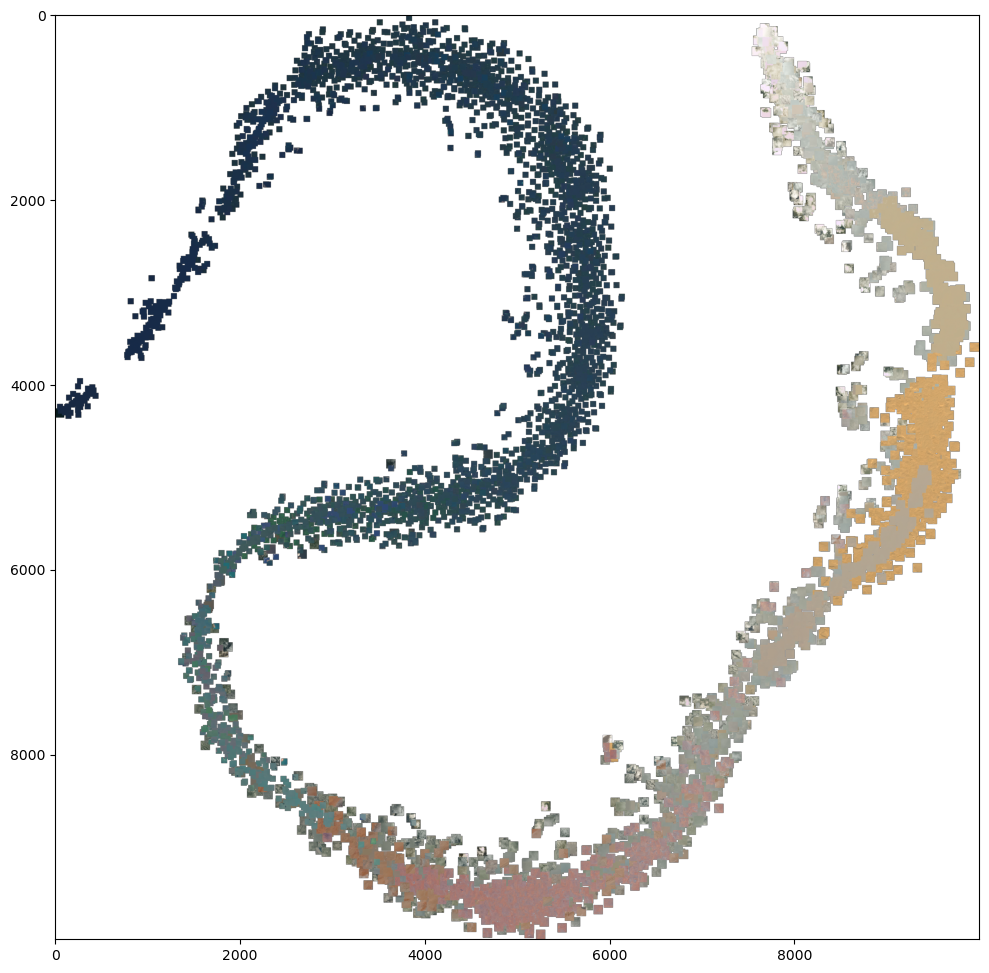

In [18]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 10000
height = 10000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [19]:
# total_step = len(train_loader)
# import time
# print_every = len(train_loader) - 1
# loss_values = []
# start_time = time.time()
# total_step = len(train_loader)
# epoch_times = []

# # Training 
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_loader): 
#         epoch_start_time = time.time()
#         running_loss = 0.0
#         images = images.to(device)
#         labels = labels.to(device)
        
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() 
#         if (i+1) % print_every == 0:
#             epoch_times.append(time.time() - epoch_start_time)
#             loss_values.append(running_loss / print_every)
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
#                    .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
#             running_loss = 0
# end_of_training = time.time() - start_time



# arr_pred = np.empty((0,len(test_dataset)), int)

# arr_label = np.empty((0,len(test_dataset)), int)

# # Prediction
# with torch.no_grad(): 
#     correct = 0
#     total = 0
#     for images, labels in test_loader: 
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
        
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         pred = predicted.cpu().numpy()
#         lb = labels.cpu().numpy()
#         arr_pred = np.append(arr_pred, pred)
#         arr_label = np.append(arr_label, lb)
        
#     print('Test Accuracy of the model on the ' + str(len(test_dataset)) + ' test images: {} %'.format(100 * correct / total))